# Using the Dimensions API to Explore UCSD Research

This notebook explores Dimensions, an API that contains information about research publications, grants, datasets and more. We are specifically interested in research done at UCSD and affliated groups. In this notebook, I explore which publishers are used and collaborations between UCSD and other universities. 

# Contents:
1. [An Overview of Using Dimcli to Access Dimensions Data](#overview)
2. [Retrieving the Data](#data)
3. [Publishers](#publishers)
4. [Topic Analysis](#topics)
5. [Datasets](#datasets)
6. [Affiliations and Collaborations](#collabs)

To start off with, I primarily use Dimcli, a Python client for accessing the Dimensions API, which helps authenticate into the API and handle query requests/responses.

In [1]:
# necessary imports
import dimcli
import pandas as pd
import numpy as np
import json

# visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
# visualization settings
sns.set_style("white")
sns.set(rc={'figure.figsize':(12, 10)})

In [3]:
# get access with config file. resource: https://digital-science.github.io/dimcli/getting-started.html# 
dimcli.login()

Searching config file credentials for default 'live' instance..


Dimcli - Dimensions API Client (v1.2)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.9
Method: dsl.ini file


In [4]:
dsl = dimcli.Dsl()

# An Overview of Using Dimcli to Access Dimensions Data <a class="anchor" id="overview"></a>

One way to query data from the API is using the dimcli instance to make queries. You can specify different conditions, such as how many objects to return, time period to search, and where to search for the keyword.

In [5]:
# note: you can also use the data attribute to get JSON of info!
dsl.query("search publications for \"malaria\" return publications limit 1")

Returned Publications: 1 (total = 1037135)
Time: 0.69s
WARNINGS [1]
Field current_organization_id of the authors field is deprecated and will be removed in the next major release.


<dimcli.DslDataset object #1441604597408. Records: 1/1037135>

Another way to query information is to use Dimcli magic commands, created specifically for the Jupyter environment, that run faster. This specific command returns a pandas dataframe.

In [6]:
%%dsldf

search publications 
    for "malaria"
return publications [title + research_orgs + research_org_names + times_cited + funders]
limit 5

Returned Publications: 5 (total = 1038969)
Time: 2.15s


title  \
0  Case-based malaria surveillance and response: ...   
1  Spatio-temporal patterns of malaria in Nepal f...   
2  Laboratory diagnosis for malaria in the elimin...   
3  Cross-sectional prevalence and pattern of non-...   
4  Trends in malaria indicators after scale-up of...   

                                             funders  \
0  [{'acronym': 'BMGF ', 'city_name': 'Seattle', ...   
1                                                NaN   
2  [{'acronym': 'BMGF ', 'city_name': 'Seattle', ...   
3                                                NaN   
4  [{'acronym': 'NIMH', 'city_name': 'Bethesda', ...   

                                  research_org_names  \
0  [Yangzhou University, Nanjing Medical Universi...   
1                            [University of Florida]   
2        [National Institute for Parasitic Diseases]   
3  [MRC Unit the Gambia, Usmanu Danfodiyo Univers...   
4  [United Nations Development Programme, Kabul, ...   

                                       research_orgs  times_cited  
0  [{'acronym': 'NMU', 'city_name': 'Nanjing', 'c...            2  
1  [{'acronym': 'UF', 'city_name': 'Gainesville',...            1  
2  [{'acronym': 'NIPD', 'city_name': 'Shanghai', ...           12  
3  [{'acronym': 'UDUTH', 'city_name': 'Sokoto', '...            0  
4  [{'acronym': 'UCSF', 'city_name': 'San Francis...            2

In [8]:
# all magic commands result stored in..
dsl_last_results.head()

title  \
0  Case-based malaria surveillance and response: ...   
1  Spatio-temporal patterns of malaria in Nepal f...   
2  Laboratory diagnosis for malaria in the elimin...   
3  Cross-sectional prevalence and pattern of non-...   
4  Trends in malaria indicators after scale-up of...   

                                             funders  \
0  [{'acronym': 'BMGF ', 'city_name': 'Seattle', ...   
1                                                NaN   
2  [{'acronym': 'BMGF ', 'city_name': 'Seattle', ...   
3                                                NaN   
4  [{'acronym': 'NIMH', 'city_name': 'Bethesda', ...   

                                  research_org_names  \
0  [Yangzhou University, Nanjing Medical Universi...   
1                            [University of Florida]   
2        [National Institute for Parasitic Diseases]   
3  [MRC Unit the Gambia, Usmanu Danfodiyo Univers...   
4  [United Nations Development Programme, Kabul, ...   

                                       research_orgs  times_cited  
0  [{'acronym': 'NMU', 'city_name': 'Nanjing', 'c...            2  
1  [{'acronym': 'UF', 'city_name': 'Gainesville',...            1  
2  [{'acronym': 'NIPD', 'city_name': 'Shanghai', ...           12  
3  [{'acronym': 'UDUTH', 'city_name': 'Sokoto', '...            0  
4  [{'acronym': 'UCSF', 'city_name': 'San Francis...            2

# Retrieving the Data <a class="anchor" id="data"></a>

Let's start querying and build a pandas dataframe to do some exploratory data analysis on research done at UCSD. 

In [6]:
GRIDID_LIST = ["grid.266100.3", "grid.420234.3", "grid.413086.8"]
GRID_NAMES = ['University of California, San Diego', 'UC San Diego Health System', 
              'University of California San Diego Medical Center'] # corresponds to the grid IDs
# other possible orgs - Rady's Children hospital, Supercomputer Center

FIELDS = "title+type+year+journal+authors+research_orgs+research_org_names+publisher+times_cited+funders+authors_count+category_for"

In [7]:
# search publications from 2024, limit to 300 because of API limits
query = f"""search publications
            where research_orgs.id in {json.dumps(GRIDID_LIST)} and year=2024
            return publications[{FIELDS}] sort by year"""
result = dsl.query(query)

Returned Publications: 20 (total = 3688)
Time: 0.81s
WARNINGS [1]
Field current_organization_id of the authors field is deprecated and will be removed in the next major release.


The above query only returns 20 publications out of 3597. However, to get a more accurate understanding of all publications from 2024 at UCSD, we could instead iteratively query over the Dimension records and get 300 records at a time, which avoids Dimension restrictions on number of queries that you can make.

In [8]:
result = dsl.query_iterative(query, limit=300)

Starting iteration with limit=300 skip=0 ...
0-300 / 3688 (5.34s)
300-600 / 3688 (2.37s)
600-900 / 3688 (3.81s)
900-1200 / 3688 (6.46s)
1200-1500 / 3688 (2.05s)
1500-1800 / 3688 (3.94s)
1800-2100 / 3688 (6.45s)
2100-2400 / 3688 (4.64s)
2400-2700 / 3688 (4.31s)
2700-3000 / 3688 (4.35s)
3000-3300 / 3688 (6.04s)
3300-3600 / 3688 (1.88s)
3600-3688 / 3688 (3.90s)
===
Records extracted: 3688
Warnings:  13


In [9]:
# turn result from Dimcli query into pandas dataframe
pubs = result.as_dataframe()
pubs.head()

title  \
0  A Qualitative Study of Internal Medicine Subsp...   
1  Structural Studies of Alloyed and Nanoparticle...   
2  Structured Network Games: Leveraging Relationa...   
3  Expert Perspectives on Controversies in Metast...   
4  Expert Perspectives on Controversies in Castra...   

                                             authors  authors_count  \
0  [{'affiliations': [{'city': 'Bloomington', 'ci...              7   
1  [{'affiliations': [{'city': 'Ames', 'city_id':...             13   
2  [{'affiliations': [{'city': 'Ann Arbor', 'city...              3   
3  [{'affiliations': [{'city': 'Phoenix', 'city_i...             38   
4  [{'affiliations': [{'city': 'San Diego', 'city...             38   

                                        category_for  \
0  [{'id': '80104', 'name': '3901 Curriculum and ...   
1  [{'id': '80066', 'name': '3402 Inorganic Chemi...   
2                                                NaN   
3  [{'id': '80003', 'name': '32 Biomedical and Cl...   
4  [{'id': '80003', 'name': '32 Biomedical and Cl...   

                                           publisher  \
0              Journal of Graduate Medical Education   
1                    American Chemical Society (ACS)   
2  Institute of Electrical and Electronics Engine...   
3                                     Wolters Kluwer   
4                                     Wolters Kluwer   

                                  research_org_names  \
0  [University of Chicago, University of Californ...   
1  [Clemson University, Iowa State University, Un...   
2  [University of Michigan–Ann Arbor, University ...   
3  [New York University Langone Medical Center, M...   
4  [New York University Langone Medical Center, U...   

                                       research_orgs  times_cited      type  \
0  [{'city_name': 'Aurora', 'country_code': 'US',...            0   article   
1  [{'acronym': 'UCSD', 'city_name': 'San Diego',...            0  preprint   
2  [{'acronym': 'UM', 'city_name': 'Ann Arbor', '...            0   article   
3  [{'acronym': 'HCI', 'city_name': 'Salt Lake Ci...            0   article   
4  [{'acronym': 'HCI', 'city_name': 'Salt Lake Ci...            1   article   

   year    journal.id                                      journal.title  \
0  2024  jour.1042740              Journal of Graduate Medical Education   
1  2024  jour.1315496                                           ChemRxiv   
2  2024  jour.1152524  IEEE Transactions on Network Science and Engin...   
3  2024  jour.1450198                                       JU Open Plus   
4  2024  jour.1450198                                       JU Open Plus   

  funders  
0     NaN  
1     NaN  
2     NaN  
3     NaN  
4     NaN

In [10]:
pubs.shape

(3688, 13)

Next, I clean the data and reformat it to make it easier to work with. Specifically, I extract the funder name into a separate column and also extract the category names from dictionaries of information into lists with just the category name, as categorized by the Australian and New Zealand Standard Research Classification (ANZSRC).

In [11]:
# the funders information is given a list of dictionaries, each dictionary represents the info for a funder
# check if it's a float because some of the column values are NaN
pubs['funder_name'] = pubs['funders'].apply(lambda x : [] if isinstance(x, float)
                                            else [dict['name'] for dict in x])

In [12]:
# category_for format is a list of dictionaries, each dictionary containing the keys id and name
# only include broad categories from the ANZSRC, which have 2-digit codes 
pubs['overall_cat'] = pubs['category_for'].apply(lambda x : [] if isinstance(x, float)
                                                 else [dict['name'] for dict in x if not dict['name'][0:4].isdigit()])

# Publishers <a class="anchor" id="publishers"></a>

Let's explore which publishers are UCSD researchers publishing in, so we can compare to the current contracts the library has with publishers. Below, I create a simple dataframe and remove the publishers with less than ten publications to simplify our visualization.

In [27]:
# create dataframe to combine the publishers with only 1 publication into the group Other
count_publisher = pubs['publisher'].value_counts().reset_index()
other_num = count_publisher[count_publisher['publisher'] < 10]['publisher'].sum()
count_publisher = count_publisher[count_publisher['publisher'] >= 10] # delete publishers with <4 publications
# count_publisher.loc[len(count_publisher)] = ['Other', other_num] # add row for the Other
count_publisher.head()

index  publisher
0                       Elsevier        880
1                Springer Nature        479
2                          Wiley        246
3  Cold Spring Harbor Laboratory        210
4                 Wolters Kluwer        193

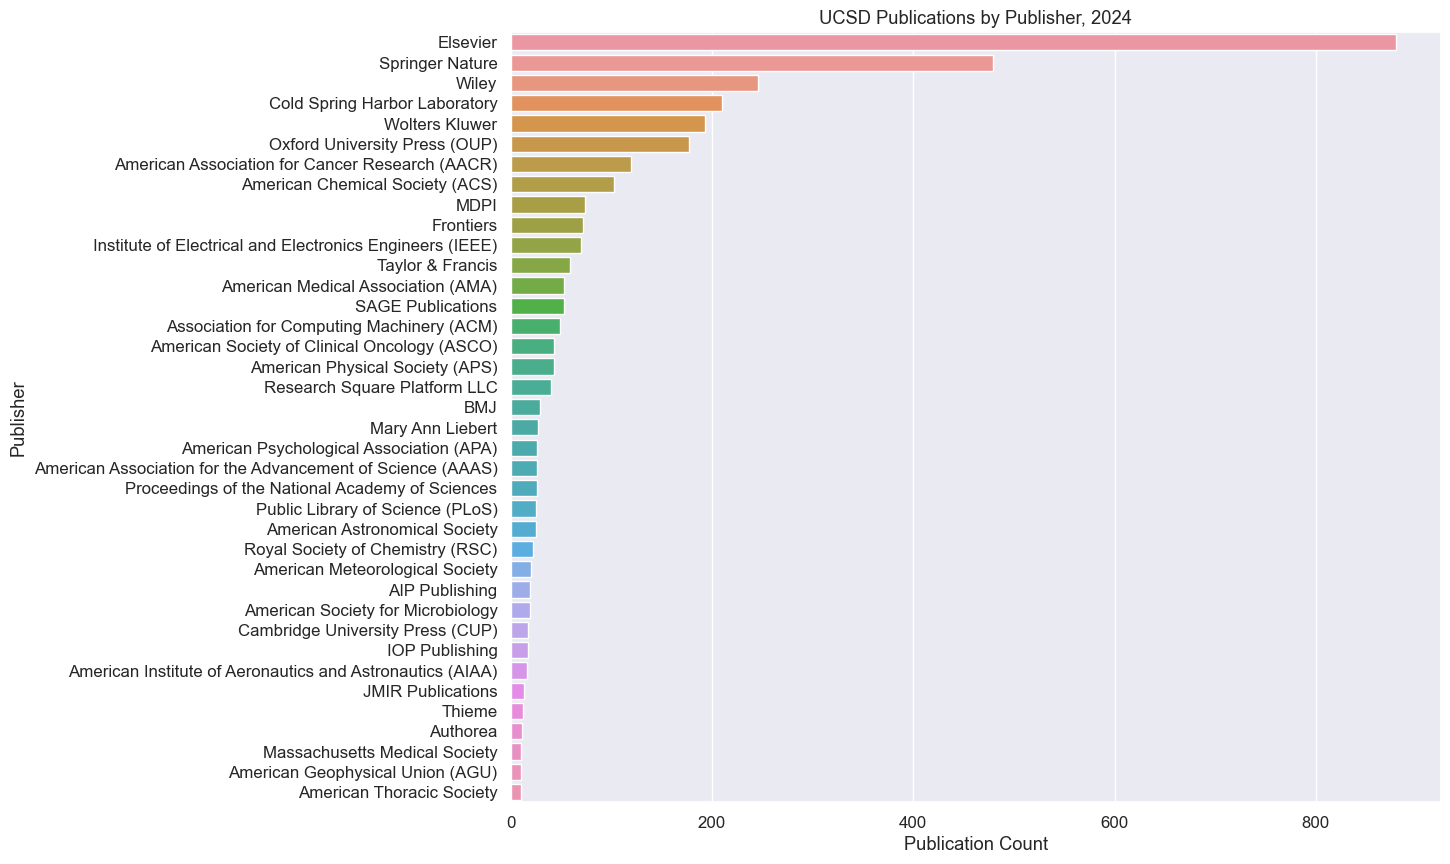

In [19]:
sns.set(font_scale=1.1)
sns.barplot(count_publisher, x="publisher", y="index", order=count_publisher['index'])
plt.xlabel('Publication Count')
plt.ylabel('Publisher')
plt.title('UCSD Publications by Publisher, 2024')
plt.show()

Originally, I had a pie chart to visualize this information, but later switched to a bar graph, which displays a large number of publishers more clearly and allows viewers to more accurately gage how many publications there are in each category. 

I notice that the top publishers in 2024 are Elsevier, Springer Nature, and Wiley. Does this breakdown change based on domain? For example, do researchers in Biology publish in different places than researchers in the Computer Science department? 

To explore this question, I wrote a function to go through the publications and filter those in a specified category to look at their publishers specifically. Then, I plotted the top 10 publishers for three different domains.

In [118]:
# category: string representing category we want to visualize publishers for
# return: a dataframe, sorted descending
def createDomainDf(category):
    count_publisher = pd.DataFrame(columns=['publisher', 'count'])
    count_publisher = count_publisher.set_index('publisher')
    
    # loop through all publications and look at their list of categories
    for i in range(0, len(pubs)): 
        curr_cat = pubs['overall_cat'][i] # list of categories
        if category in curr_cat:
            if pubs['publisher'][i] in count_publisher.index.unique():
                count_publisher.loc[pubs['publisher'][i]] += 1
            else:
                count_publisher.loc[pubs['publisher'][i]] = 1

    return count_publisher.sort_values(by=['count'], ascending=False)

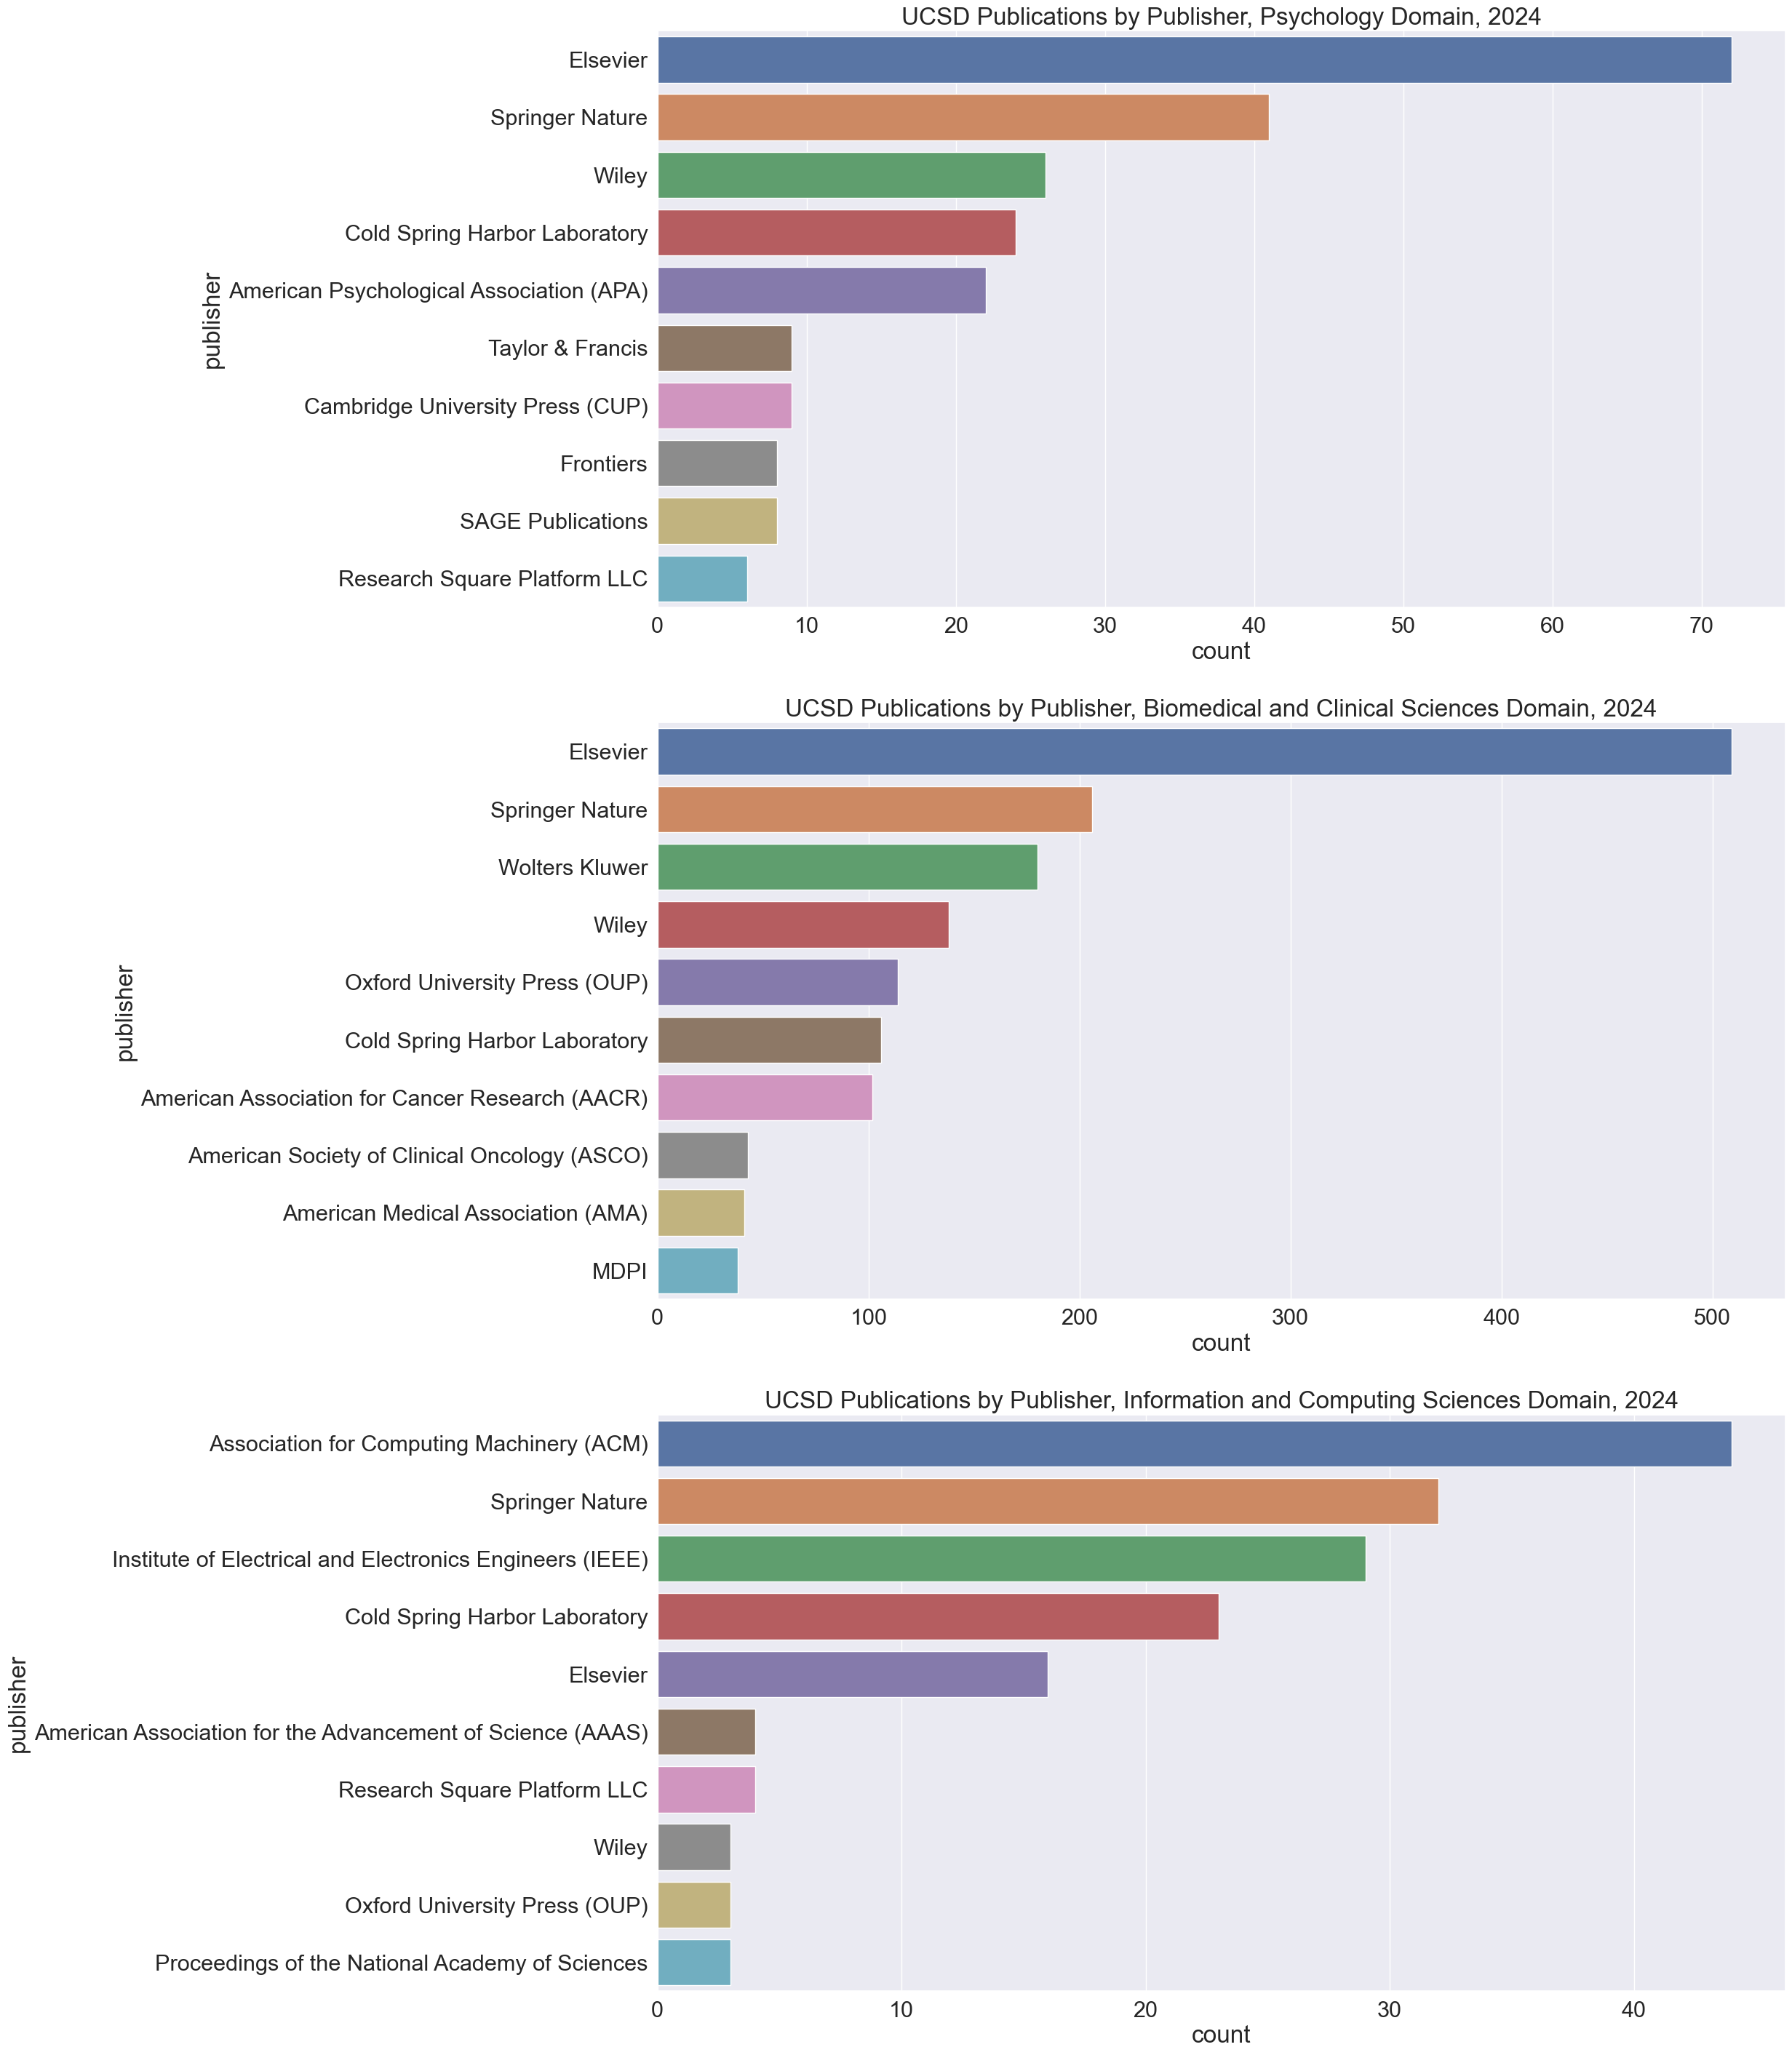

In [119]:
sns.set(font_scale=2)
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(20, 35))
sns.barplot(ax=ax1, x=createDomainDf('52 Psychology')['count'][0:10], y=createDomainDf('52 Psychology').index[0:10])
ax1.set_title('UCSD Publications by Publisher, Psychology Domain, 2024')
sns.barplot(ax=ax2, x=createDomainDf('32 Biomedical and Clinical Sciences')['count'][0:10], 
                  y=createDomainDf('32 Biomedical and Clinical Sciences').index[0:10])
ax2.set_title('UCSD Publications by Publisher, Biomedical and Clinical Sciences Domain, 2024')
sns.barplot(ax=ax3, x=createDomainDf('46 Information and Computing Sciences')['count'][0:10], 
                  y=createDomainDf('46 Information and Computing Sciences').index[0:10])
ax3.set_title('UCSD Publications by Publisher, Information and Computing Sciences Domain, 2024')
plt.show()

# Topic Analysis <a class="anchor" id="topics"></a>

Another thing we can do with Dimensions data is do topic analysis. Topic Analysis is a natural language processing technique that allows us to extract topics and concepts from text and find patterns/meaning. 

For this section, I'll focus on one specific domain from the ANZSRC classification system, from UCSD research. I query information from Dimensions again specifically for this domain. There's also a great tutorial on this from Dimensions: <a href=https://api-lab.dimensions.ai/cookbooks/2-publications/Simple-topic-analysis.html>Topic Analysis<a>.

In [132]:
FOR = "5204 Cognitive and computational psychology" 

query = f"""
search publications
    where research_orgs.id = "{GRIDID_LIST[0]}"
    and category_for.name= "{FOR}"
    return publications[id+doi+concepts_scores+year]
"""

print("===\nQuery:\n", query)
print("===\nRetrieving Publications.. ")
data = dsl.query_iterative(query)

Starting iteration with limit=1000 skip=0 ...


===
Query:
 
search publications
    where research_orgs.id = "grid.266100.3"
    and category_for.name= "5204 Cognitive and computational psychology"
    return publications[id+doi+concepts_scores+year]

===
Retrieving Publications.. 


0-1000 / 3710 (2.63s)
1000-2000 / 3710 (6.07s)
2000-3000 / 3710 (5.73s)
3000-3710 / 3710 (1.86s)
===
Records extracted: 3710


In [133]:
# process concept data
concepts = data.as_dataframe_concepts() # turn concepts into df with one row per concept
concepts_unique = concepts.drop_duplicates("concept")[['concept', 'frequency', 'score_avg']] # process duplicates
concepts_unique

concept  frequency  score_avg
0       mild cognitive impairment         19    0.66884
1                    event memory          2    0.64350
2                        non-aMCI          1    0.62400
3              retrograde amnesia          3    0.59367
4                  cognitive risk          2    0.57950
...                           ...        ...        ...
157836              head-vertical          1    0.44200
157841      orientation constancy          1    0.40600
157842             cortical units          1    0.40500
157850                       horn          1    0.32100
157852                  body tilt          1    0.32000

[43321 rows x 3 columns]

In [134]:
# Figure out best parameters to define interesting and relevant concepts
# Frequency: how many documents include a concept (100 = no upper limit).
# Tip: concepts with very high frequencies tend to be common words, so it is useful to exclude them.
FREQ_MIN = 2
FREQ_MAX = 70
# Score: the average relevancy score of concepts, for the dataset we extracted above. good indicator of interesting concepts
SCORE_MIN = 0.4 
# Concepts to include in the visualization:
MAX_CONCEPTS = 200

if FREQ_MAX == 100:
  FREQ_MAX = 100000000

filtered_concepts = concepts_unique.query(f"""frequency >= {FREQ_MIN} & frequency <= {FREQ_MAX} & score_avg >= {SCORE_MIN} """)\
                    .sort_values(["score_avg", "frequency"], ascending=False)[:MAX_CONCEPTS]

px.scatter(filtered_concepts,
           x="concept",
           y="frequency",
           height=700,
           color="score_avg",
           size="score_avg")

Based on this plot, we have an idea of which concepts are occurring in higher frequency and which concepts are deemed more relevant with higher relevance scores and darker colors. I'm also curious about how these topics relate to each other, so let's build a concepts co-occurrence network, using the following Dimensions tutorial: <a href="https://api-lab.dimensions.ai/cookbooks/2-publications/Concepts-network-graph.html">Concepts Network Graph<a>.

In [147]:
concepts_net = data.as_dataframe() # previously queried data with concepts as lists for each publication
concepts_net.head()

id                                    concepts_scores  \
0  pub.1170704794  [{'concept': 'mild cognitive impairment', 'rel...   
1  pub.1170565009  [{'concept': 'early word learning', 'relevance...   
2  pub.1170407122  [{'concept': 'real-world stimuli', 'relevance'...   
3  pub.1170396199  [{'concept': 'color memory task', 'relevance':...   
4  pub.1170368199  [{'concept': 'leucine-rich repeat kinase 2', '...   

                                      doi  year  
0  10.1016/j.neuropsychologia.2024.108887  2024  
1                      10.1111/desc.13510  2024  
2                      10.1037/dev0001735  2024  
3                      10.1037/xlm0001339  2024  
4              10.1038/s41531-024-00683-5  2024

In [148]:
import networkx as nx
G = nx.Graph()

In [ ]:
MIN_CONCEPT_SCORE = 0.6
MIN_CONCEPT_FREQUENCY = 4
MIN_CONCEPT_FREQUENCY = 4
MIN_EDGE_WEIGHT = 2

# Datasets <a class="anchor" id="datasets"></a>

At UCSD, where are people publishing datasets? 

In [15]:
#%dsldf search datasets for "machine learning" return datasets

# Affliations and Collaborations<a class="anchor" id="collabs"></a>

Let's find out which universities UCSD, and other affliated organizations like UCSD Health and UCSD Medical Center, are collaborating with on publications. We analyze these collaborations by looking at which research organizations are listed for each publication. 

In [135]:
# build df with geographical information and collaborations info
# includes collaborations with the 3 different UCSD related grid IDs
# loop through all research_orgs 
collabs = pd.DataFrame(columns=['lat', 'long', 'collabNum', 'type'])
for orgs_list in pubs['research_orgs']:
    for org in orgs_list:
        if 'latitude' not in org or 'longitude' not in org: # if org doesn't have lat/long info, skip it
            print(org)
            continue
        if org['name'] in GRID_NAMES: # if org is UCSD related, skip
            continue
        if org['name'] not in collabs.index:
            collabs.loc[org['name']] = [org['latitude'], org['longitude'], 1, org['types'][0]]
        else: # uni already in the dataframe
            collabs.at[org['name'], 'collabNum'] += 1

{'acronym': 'ASAP', 'city_name': 'San Francisco', 'country_code': 'US', 'country_name': 'United States', 'id': 'grid.513948.2', 'linkout': ['https://parkinsonsroadmap.org/'], 'name': 'Aligning Science Across Parkinson’s', 'state_name': 'California', 'types': ['Nonprofit']}
{'acronym': 'ASAP', 'city_name': 'San Francisco', 'country_code': 'US', 'country_name': 'United States', 'id': 'grid.513948.2', 'linkout': ['https://parkinsonsroadmap.org/'], 'name': 'Aligning Science Across Parkinson’s', 'state_name': 'California', 'types': ['Nonprofit']}
{'acronym': 'ASAP', 'city_name': 'San Francisco', 'country_code': 'US', 'country_name': 'United States', 'id': 'grid.513948.2', 'linkout': ['https://parkinsonsroadmap.org/'], 'name': 'Aligning Science Across Parkinson’s', 'state_name': 'California', 'types': ['Nonprofit']}
{'acronym': 'ASAP', 'city_name': 'San Francisco', 'country_code': 'US', 'country_name': 'United States', 'id': 'grid.513948.2', 'linkout': ['https://parkinsonsroadmap.org/'], 'na

Now, we use the dataframe we built to plot this information on a Plotly bubble map, with larger circles indicating more collaborations. 

In [121]:
fig = px.scatter_geo(collabs, lat='lat', lon='long', hover_name=collabs.index, size='collabNum', 
                     color='collabNum', color_continuous_scale="sunset_r")
fig.show()

We notice that the universities with the highest number of collaborations are mainly centered in the US and include Harvard, John Hopkins, UCSF, and Stanford. It also seems to correspond with highly population densities in the US. 

We notice that some lists of research orgs are quite long. We look at why this is by creating a visualization for number of research_org_names versus number of authors. 

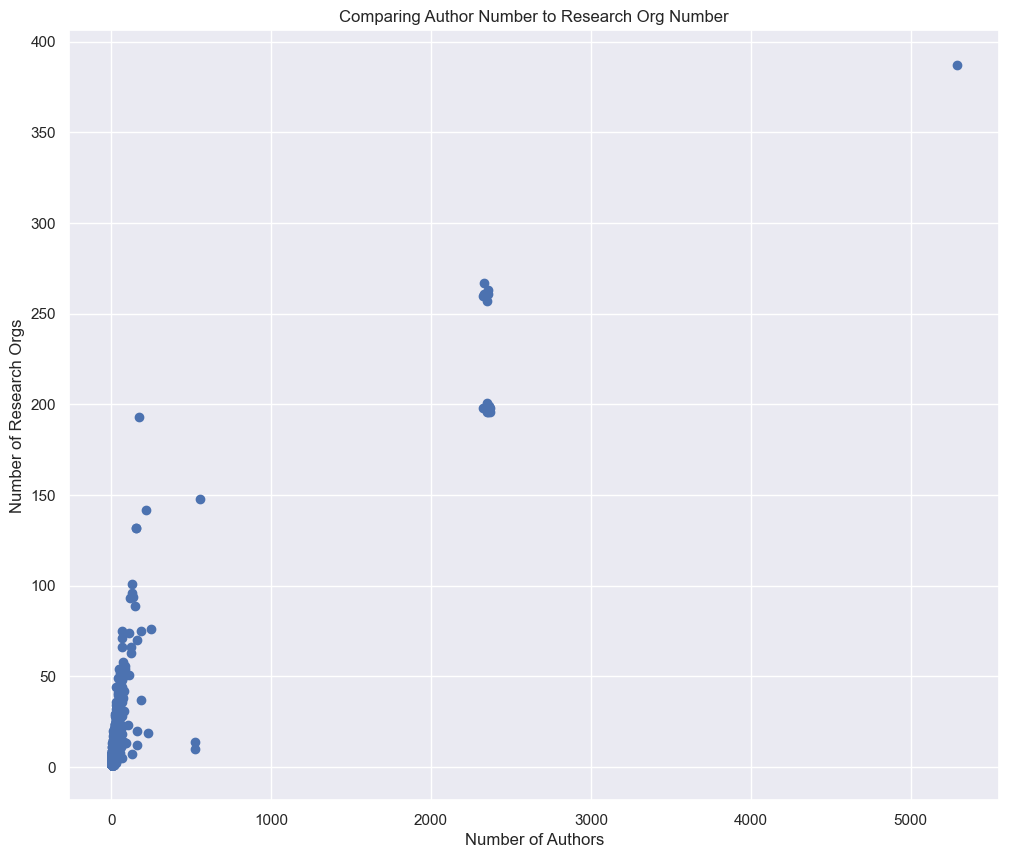

In [30]:
plt.scatter(pubs['authors_count'], pubs['research_org_names'].apply(lambda ls : len(ls)))
plt.xlabel('Number of Authors')
plt.ylabel('Number of Research Orgs')
plt.title('Comparing Author Number to Research Org Number')
plt.show()

We notice that there is a very general trend of number of research orgs increasing when number of authors increase. We can guess that this is because the authors might be affliated with different research organizations. Furthermore, we notice that astonishingly, some publications have more than 1000 authors.

In [13]:
len(pubs[pubs['authors_count'] > 1000])

18